In [1]:
import torch
import os
import math
from transformers import pipeline
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt

image_path = "./img/test1.png"
image = Image.open(image_path).convert("RGB")

MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)
os.environ['HF_HOME'] = MODEL_DIR

In [2]:
feature_extractor = pipeline(
    model="./models/dinov3-vith16plus-pretrain-lvd1689m",
    task="image-feature-extraction",
    device=0 if torch.cuda.is_available() else -1,
)

Device set to use cuda:0


In [3]:
features = feature_extractor(image)   # (1, num_tokens, dim)
features = torch.tensor(features).squeeze(0)  # (num_tokens, dim)

前景候选点 (patch 坐标): [[8 8]]
自动生成的前景框: [240. 180. 560. 360.]


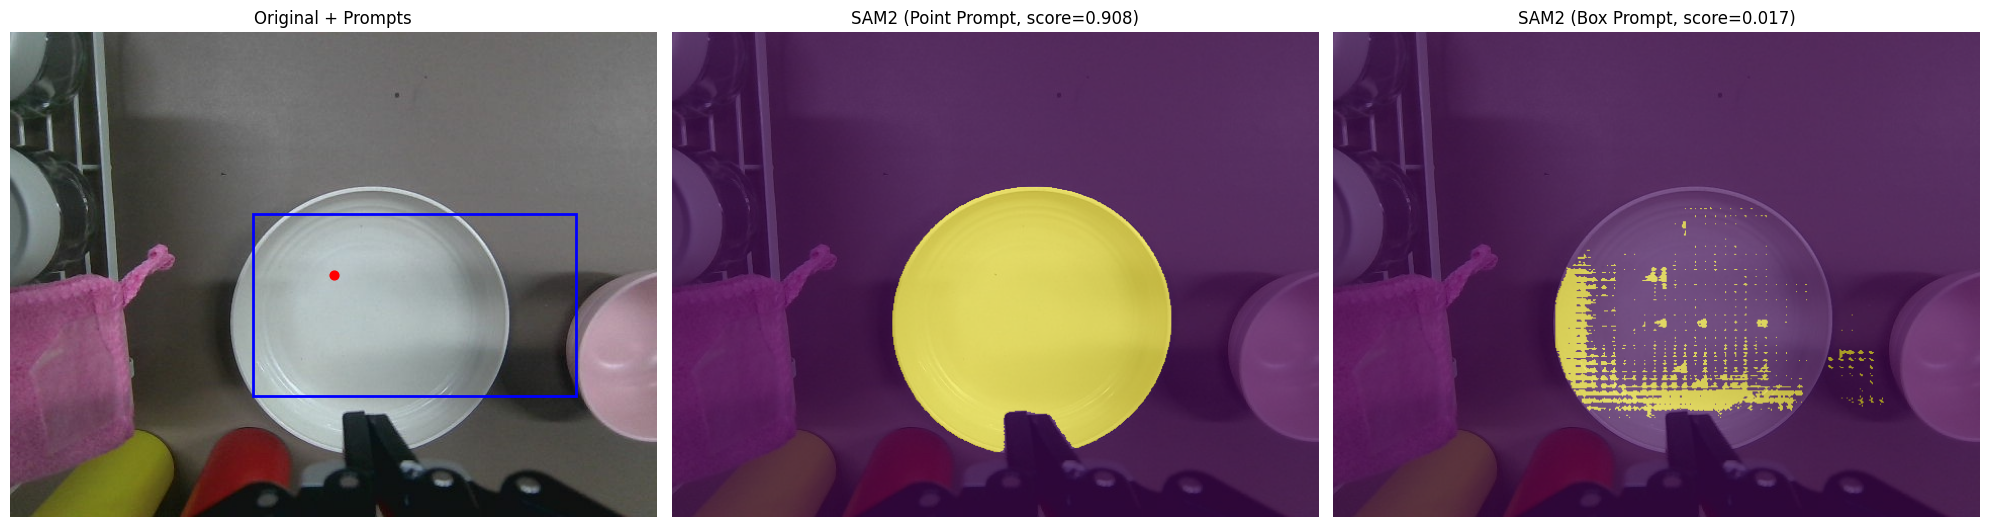

In [11]:


# token 划分
num_tokens = features.shape[0]
num_patches_guess = int(math.sqrt(num_tokens))**2
h = w = int(math.sqrt(num_patches_guess))
num_special_tokens = num_tokens - num_patches_guess
patch_features = features[num_special_tokens:, :]  # 去掉 [CLS] 等特殊 token

# 选择种子 patch（这里选中间的一个 patch）
# 理想中的话，最好能在这里融合语义信息来选择patch(选择需要操作的物体)
# 也就是说，seed_idx 作为语义输入的点，选择这个点
seed_idx = (h // 2) * w + (w // 2)
seed_vec = patch_features[seed_idx].unsqueeze(0).numpy()  # (1, dim)

# 与所有 patch 计算 cosine 相似度
sims = cosine_similarity(seed_vec, patch_features.numpy())[0]
sim_map = sims.reshape(h, w)

# 取相似度高的点(>0.5), 防止在同一区域检测到多个相邻的峰值点
peak_coords = peak_local_max(sim_map, min_distance=3, threshold_abs=0.8)
print("前景候选点 (patch 坐标):", peak_coords)

# 映射回原图坐标
scale_x = image.size[0] / w
scale_y = image.size[1] / h
prompt_points = np.array([[x * scale_x, y * scale_y] for y, x in peak_coords])


mask_thresh = sim_map > 0.6
ys, xs = np.where(mask_thresh)
if len(xs) > 0:
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    prompt_box = np.array([x_min * scale_x, y_min * scale_y,
                           x_max * scale_x, y_max * scale_y])
else:
    prompt_box = None

print("自动生成的前景框:", prompt_box)

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

device = "cuda" if torch.cuda.is_available() else "cpu"
sam2_checkpoint = "./models/sam2/sam2_hiera_base_plus.pt"
model_cfg = "configs/sam2/sam2_hiera_b+.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image)

# 点提示
if len(prompt_points) > 0:
    masks_points, scores_points, _ = predictor.predict(
        point_coords=prompt_points,
        point_labels=np.ones(len(prompt_points)),  # 全部标记为前景
        multimask_output=True,
    )
else:
    masks_points, scores_points = [], []

# 框提示
if prompt_box is not None:
    masks_box, scores_box, _ = predictor.predict(
        box=prompt_box[None, :],
        multimask_output=True,
    )
else:
    masks_box, scores_box = [], []

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# 原图 + 提示
axes[0].imshow(image)
if len(prompt_points) > 0:
    axes[0].scatter(prompt_points[:, 0], prompt_points[:, 1], c='red', s=40)
if prompt_box is not None:
    x0, y0, x1, y1 = prompt_box
    rect = plt.Rectangle((x0, y0), x1-x0, y1-y0, fill=False, edgecolor='blue', linewidth=2)
    axes[0].add_patch(rect)
axes[0].set_title("Original + Prompts")
axes[0].axis('off')

# 点提示结果
if len(masks_points) > 0:
    axes[1].imshow(image)
    axes[1].imshow(masks_points[0], alpha=0.6)
    axes[1].set_title(f"SAM2 (Point Prompt, score={scores_points[0]:.3f})")
    axes[1].axis('off')

# 框提示结果
if len(masks_box) > 0:
    axes[2].imshow(image)
    axes[2].imshow(masks_box[0], alpha=0.6)
    axes[2].set_title(f"SAM2 (Box Prompt, score={scores_box[0]:.3f})")
    axes[2].axis('off')

plt.tight_layout()
plt.show()


In [12]:
scores_points

array([0.9077018 , 0.00569164, 0.43938103], dtype=float32)

In [13]:
scores_box

array([0.01679905, 0.17599817, 0.21036819], dtype=float32)

In [14]:
prompt_points

array([[320., 240.]])

In [2]:
prompt_points = np.array([[320. , 240.]])
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

device = "cuda" if torch.cuda.is_available() else "cpu"
sam2_checkpoint = "./models/sam2/sam2_hiera_base_plus.pt"
model_cfg = "configs/sam2/sam2_hiera_b+.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

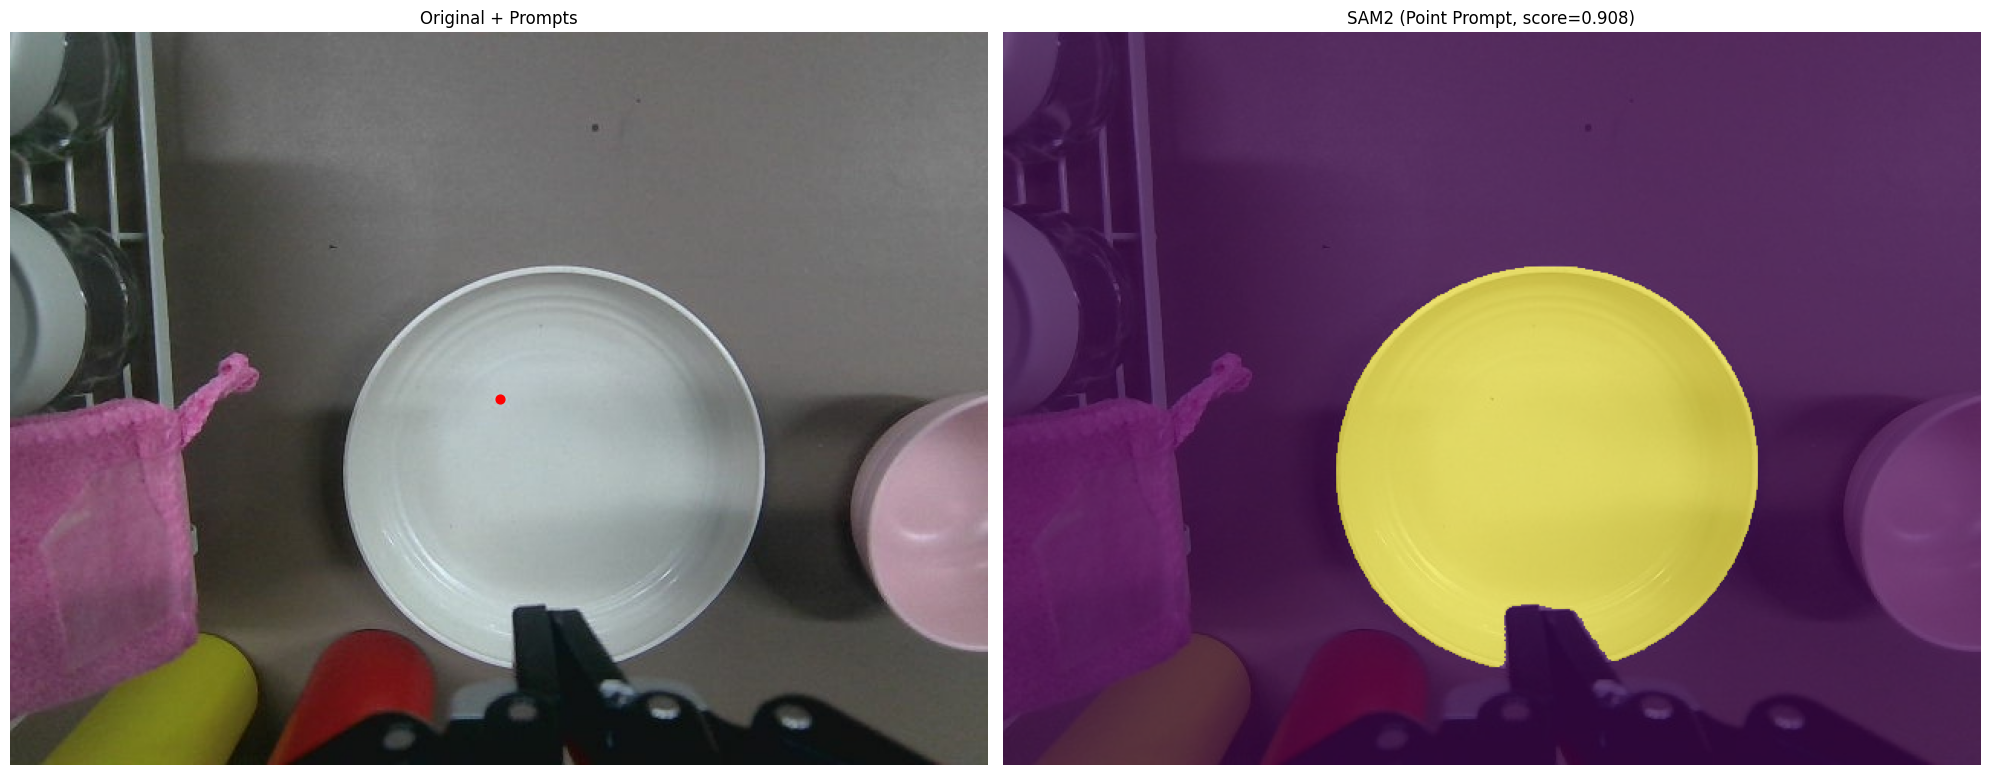

In [3]:
predictor.set_image(image)

# 点提示
if len(prompt_points) > 0:
    masks_points, scores_points, _ = predictor.predict(
        point_coords=prompt_points,
        point_labels=np.ones(len(prompt_points)),  # 全部标记为前景
        multimask_output=True,
    )
else:
    masks_points, scores_points = [], []

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 原图 + 提示
axes[0].imshow(image)
if len(prompt_points) > 0:
    axes[0].scatter(prompt_points[:, 0], prompt_points[:, 1], c='red', s=40)
axes[0].set_title("Original + Prompts")
axes[0].axis('off')

# 点提示结果
if len(masks_points) > 0:
    axes[1].imshow(image)
    axes[1].imshow(masks_points[0], alpha=0.6)
    axes[1].set_title(f"SAM2 (Point Prompt, score={scores_points[0]:.3f})")
    axes[1].axis('off')

plt.tight_layout()
plt.show()

这里或许应该做一个最大分数值的选择，选择置信度最高的分数点

In [4]:
scores_points

array([0.9077018 , 0.00569164, 0.43938103], dtype=float32)